This notebook shows basically how to do everything from `mask_9.ncl` of the NCL examples.

The point is to use a shapefile. First just to get the shape(s) and plot it/them on a map. Then to use the shape as a way to mask some data, so we end up with a plot of the data only in the shape (or out of it).

There are a bunch of ways to read shapefiles with python. Here we just use the basic one, `shapefile`. Using that package's `Reader` method, gives a list of shapes; in this example there's just one shape. The shape has a long list of points in it that give (longitude, latitude) pairs. We will just take these pairs as values, and plot them as a matplotlib polygon. 

To use the shape as a mask, we construct a path in the appropriate coordinates and then get all the grid points that are inside that path to define a mask. For this we use the `path` module of matplotlib.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [23]:
# New for this example
import shapefile
import matplotlib.path as mplp

In [95]:

def lonFlip(data):
    # NOTE: this assumes global values
    tmplon = data['lon']
    tmpdata = data.roll(lon=(len(tmplon) // 2)-1, roll_coords=True)
    print(tmpdata)
    lonroll = tmpdata['lon'].values
    if tmplon.min() >= 0:
        # flip to -180:180
        tmpdata['lon'].values = np.where(lonroll >= 180, lonroll - 360, lonroll)
    else:
        # flip from -180:180 to 0:360
        tmpdata['lon'].values = ((lonroll + 360) % 360)
    return tmpdata


In [22]:
sfil = "/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/shp/mrb.shp"

In [24]:
sf = shapefile.Reader(sfil)

In [25]:
sf

Many shapefiles will have tons of "shapes" inside them. The following would put outlines around each of the shapes and fill them.

Finding Points
Found Points
Creating Polygon
Polygon Created


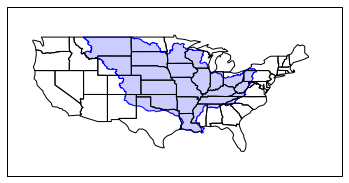

In [48]:
# 1.a Plot any shapes we find on a map.
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
ax.add_feature(cartopy.feature.STATES)
ax.set_extent([-130, -60, 20, 50])
for shape in sf.shapes():
    print("Finding Points")
    points = shape.points
    print("Found Points")    

    print("Creating Polygon")
    ap = plt.Polygon(points, facecolor=(0,0,1,.2), edgecolor="b")  # RGBa for facecolor
    ax.add_patch(ap)
    print("Polygon Created")


In [138]:
print(f"Number of shapes in sf: {len(sf.shapes())}")  # Only one shape in this shapefile
# So we could just simplify
mississippi = sf.shapes()[0].points
print(f"The number of coordinates in shape is {len(mississippi)}")
print(f"Example coordinate (the first one) is {mississippi[0]}")

Number of shapes in sf: 1
The number of coordinates in shape is 88565
Example coordinate (the first one) is (-114.05845865453524, 48.996857312063305)


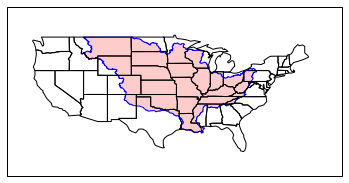

In [49]:
# 1.b Plot the shape on a map
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
ax.add_feature(cartopy.feature.STATES)
ax.set_extent([-130, -60, 20, 50])
apatch = plt.Polygon(mississippi, edgecolor="b", facecolor=(1,0,0,.2))
ax.add_patch(apatch)


In [96]:
# NCL example made up fake data, but let's just grab one of the netCDF files
ds = xr.open_dataset("/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/era40.pl.t85.tuvo.200001.nc")
data = ds["T"][0,-3,:,:]
lons, lats = np.meshgrid(ds['lon'], ds['lat'])

In [98]:
# The shapefile uses -180:180, but the file we grabbed uses 0:360
# Let's flip the data.
# NOTE: I think the lonFlip function needs some fine-tuning in how it rolls the data.
#       I had an off-by-one error that rolled too much.
dsflip = lonFlip(ds)

<xarray.Dataset>
Dimensions:     (lat: 128, lev: 23, lon: 256, time: 1)
Coordinates:
  * lat         (lat) float32 -88.927734 -87.538704 ... 87.538704 88.927734
  * lev         (lev) int32 1 2 3 5 7 10 20 30 ... 500 600 700 775 850 925 1000
  * lon         (lon) float32 181.374 182.78 184.186 ... 177.156 178.562 179.968
  * time        (time) datetime64[ns] 2000-01-01
Data variables:
    OMEGA       (time, lev, lat, lon) float32 5.889684e-06 ... 0.00050753355
    date        (time) int32 ...
    datesec     (time) int32 ...
    gw          (lat) float32 ...
    yyyymmddhh  (time) int32 ...
    T           (time, lev, lat, lon) float32 287.71768 287.71964 ... 246.97006
    U           (time, lev, lat, lon) float32 -0.6944885 ... 2.8208332
    V           (time, lev, lat, lon) float32 0.4156952 ... -1.2983665
Attributes:
    title:                     \nERA40 Monthly Mean T85 Analysis on Pressure ...
    temporal_span:             \nThe entire ERA40 archive spans 45 years: Sep...
    sou

In [100]:
# how to mask using the shapefile
# helpful: https://stackoverflow.com/questions/34585582/how-to-mask-the-specific-array-data-based-on-the-shapefile
#
# We use path module in matplotlib to turn the points into a "path" (in the graphical sense),
# and then use the contains_points function to make a 1/0 True/False array.
mpath = mplp.Path(mississippi)
X, Y = np.meshgrid(dsflip['lon'], dsflip['lat'])
mpoints = np.array((X.flatten(), Y.flatten())).T
mask = mpath.contains_points(mpoints).reshape(X.shape)

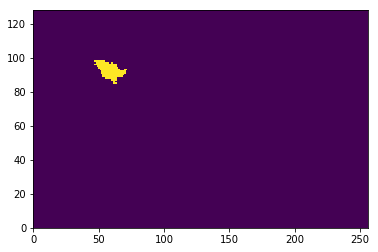

In [113]:
# Sanity check that we have created a mask
plt.pcolormesh(mask)

In [135]:
# Create masked data
# The data is basically arbitrary, but needs to 
# have coordinates that match those we've already got
# for the shapefile/shape/points (why we flipped lon).
# Then use were to keep only data inside the mask.
mdata = dsflip["T"][0,-3,:,:]
mdata = np.where(mask, mdata, np.nan)

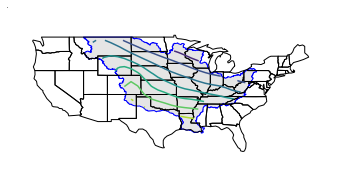

In [136]:
# 2. Plot the shape on the map and add data only in the region of the shape
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
ax.add_feature(cartopy.feature.STATES)
ax.set_extent([-130, -60, 20, 50])
apatch = plt.Polygon(mississippi, edgecolor="b", facecolor=(0,0,0,.1))
ax.add_patch(apatch)
ax.contour(X, Y, blah, transform=ccrs.PlateCarree())
# remove the frame:
ax.outline_patch.set_linewidth(0.) # https://github.com/SciTools/cartopy/issues/1077